In [1]:
PRINT_FLAG = False

In [2]:
import random
import math
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import time
import pandas as pd

dataset = []
cp_dataset = []
for _ in range(1,201):
    rdm_number = random.randint(1,100)
    dataset.append((datetime.now(), rdm_number))
    cp_dataset.append(rdm_number)
    time.sleep(0.1)

## Dataset Preparation

In [3]:
# read dataset
path = '../dataset/data13to17Feb2018.csv'
df = pd.read_csv(path, usecols=['Time', 'Source', 'Destination', 'Protocol', 'Length']).dropna()

# keep only the columns that we want
df = df[['Time', 'Length']]

# transform time column to datetime object
df['Time']= pd.to_datetime(df['Time'])

In [4]:
# we want to disregard the records which have as date 1970
df['Year'] = df['Time'].dt.year
df = df[df['Year'] > 1970]
df = df[['Time', 'Length']]

In [5]:
# check how the dataset looks like
df.head()

,Time,Length
0,2019-02-13 02:13:38.346809,152
1,2019-02-13 02:13:38.347297,40
2,2019-02-13 02:13:38.678841,88
3,2019-02-13 02:13:38.679018,40
4,2019-02-13 02:16:38.390502,152


## Get a slice of the whole dataset

In [6]:
sliced_df = df[(df['Time'].dt.day == 13) & (df['Time'].dt.hour > 14) & (df['Time'].dt.hour < 16)]
sliced_df = sliced_df.iloc[0:100000]

In [7]:
# sliced_df = df[0:180000]

In [8]:
dataset = []
for index, row in sliced_df.iterrows():
    dataset.append((row['Time'], row['Length']))

In [9]:
cp_dataset = list(sliced_df['Length'])

In [10]:
sorted_cp_dataset = sorted(cp_dataset)
max_cp_dataset = sorted_cp_dataset[-1]
step = int(len(sorted_cp_dataset) / 10)
temp_cp_dataset = []
for i in range(0, len(sorted_cp_dataset)-1, step):
    temp_cp_dataset.append(sorted_cp_dataset[i])
temp_cp_dataset.append(max_cp_dataset)

In [11]:
def find_appropriate_bar_for_item(item):
    interval = item[0]
    value = item[1]
    
    if len(bars) == 0:
        bars.append(0)
        bars_dic[0] = [value, value, 1]
        EH_dic[0] = [[interval, 1]]
        blocked_bars_dic[0] = []
        return -1
    else:
        for bar in bars:
            if value >= bars_dic[bar][0] and value <= bars_dic[bar][1]:
                return bar
        if value < bars_dic[bars[0]][0]:
            bars_dic[bars[0]][0] = value
            return bars[0]
        if value > bars_dic[bars[-1]][1]:
            bars_dic[bars[-1]][1] = value
            return bars[-1]

In [12]:
def insert_item_to_bar(item, bar):
    interval = item[0]
    value = item[1]
    
    bars_dic[bar][2] += 1    
    
    EH_dic[bar].append([interval,1])
    
    all_boxes = EH_dic[bar]
    if PRINT_FLAG:
        print('all_boxes before transform: ', all_boxes)
    
    flag = True
    while flag:
        flag = False
        for i in range(len(all_boxes)-1, -1, -1):
            size = all_boxes[i][1]
            k = i
            count = 0
            while k >= 0:
                k -= 1
                if all_boxes[k][1] == size:
                    count += 1
                else:
                    break
            if count > 3:
                flag = True
                break
        
        if flag:
            last = k + 1
            next_from_last = k + 2

            box_left = all_boxes[last]
            box_next_from_last = all_boxes[next_from_last]
            new_box = [box_left[0], box_left[1] + box_next_from_last[1]]
            all_boxes.pop(next_from_last)
            all_boxes.pop(last)
            all_boxes.insert(last, new_box)
        else:
            flag = False
        if PRINT_FLAG:
            print('all_boxes after transform: ', all_boxes)

In [13]:
def remove_expired_boxes(current_interval, W):
    for bar in bars:
        bars_boxes = EH_dic[bar]
        current_i = -1
        for i in range(len(bars_boxes)-1, -1, -1):
            if bars_boxes[i][0] < current_interval:
                current_i = i
                if PRINT_FLAG:
                    print('interval: ', current_interval, ' Gonna discard this: ', bars_boxes)
                break
        if current_i != -1:
            new_boxes = bars_boxes[i+1:]
            old_boxes = bars_boxes[:i+1]
            for old_box in old_boxes:
                W = W - old_box[1]
            EH_dic[bar] = new_boxes
            if PRINT_FLAG:
                print('New boxes: ', EH_dic[bar])
    return W

In [14]:
def computeBoundaries():
    if PRINT_FLAG:
        print('.-.-.-.- COMPUTE BOUNDARIES .-..-.-.-.-')
    total_Est = 0
    for bar in bars:
        bar_size = bars_dic[bar][2]
        total_Est += bar_size
    
    if PRINT_FLAG:
        print('total_Est: ', total_Est)
    
    boundaries = [bars_dic[bars[0]][0]]
    b = - 1
    count = 0
    ideal_Buck_Size = total_Est / B
    if PRINT_FLAG:
        print('ideal_Buck_Size: ', ideal_Buck_Size)
    for i in range(B-1):
        while(count <= ideal_Buck_Size):
            if PRINT_FLAG:
                print('b: ', b)
            b += 1
            count += bars_dic[bars[b]][2]
            if PRINT_FLAG:
                print('count: ', count)
        surplus = count - ideal_Buck_Size
        if PRINT_FLAG:
            print('surplus: ', surplus)
        temp = bars_dic[bars[b]][0] + (bars_dic[bars[b]][1] - bars_dic[bars[b]][0]) * (1 - surplus/bars_dic[bars[b]][2])
        if PRINT_FLAG:
            print('temp: ', temp)
        boundaries.append(temp)
        count = surplus
    boundaries.append(bars_dic[bars[-1]][1])
    if PRINT_FLAG:
        print('.-.-.-..-.-.-.-.-.-.-..-.-.-.-.-.-.-..-.-.-.')
    return boundaries, ideal_Buck_Size

In [15]:
def findBarsToMerge():
    for i in range(len(bars)-1):
        current_bar_size = bars_dic[bars[i]][2]
        next_bar_size = bars_dic[bars[i+1]][2]
        if current_bar_size == 0 and next_bar_size == 0:
            return [i, i+1]
    
    for i in range(len(bars)-1):
        current_bar_size = bars_dic[bars[i]][2]
        next_bar_size = bars_dic[bars[i+1]][2]
        if current_bar_size == 0:
            if i >= 1:
                previous_bar = i - 1
                next_bar = i + 1
                previous_bar_size = bars_dic[bars[previous_bar]][2]
                next_bar_size = bars_dic[bars[next_bar]][2]
                if previous_bar_size <= next_bar_size:
                    if previous_bar_size < maxSize:
                        return [previous_bar, i]
                else:
                    if next_bar_size < maxSize:
                        return [i, next_bar]
            else:
                if next_bar_size < maxSize:
                    return [i, i+1]
    
    min_agg_size = sys.maxsize
    current_index = -1
    for i in range(len(bars)-1):
        current_bar_size = bars_dic[bars[i]][2]
        next_bar_size = bars_dic[bars[i+1]][2]
        if current_bar_size + next_bar_size < min_agg_size:
            min_agg_size = current_bar_size + next_bar_size
            current_index = i
    
    if min_agg_size < maxSize:
        return [current_index, current_index + 1]
    
    return [None, None]

In [16]:
def mergeBars():
    
    X_l_index, X_r_index = findBarsToMerge()
    
    if X_l_index is None or X_r_index is None:
        return False
    
    X_l = bars[X_l_index]
    X_r = bars[X_r_index]
        
    # new bar X
    X = [0, 0, 0]
    X_name = max(bars) + 1
    
    if len(EH_dic[X_l]) >= len(EH_dic[X_r]):
        EH_dic[X_name] = EH_dic[X_r]
        blocked_bars_dic[X_name] = [X_l]
    else:
        EH_dic[X_name] = EH_dic[X_l]
        blocked_bars_dic[X_name] = [X_r]
    
    temp_list = blocked_bars_dic[X_l] + blocked_bars_dic[X_r]
    blocked_bars_dic[X_name].extend(temp_list)
    
    X[0] = bars_dic[X_l][0]
    X[1] = bars_dic[X_r][1]
    X[2] = bars_dic[X_l][2] + bars_dic[X_r][2]
    
    bars.pop(X_r_index)
    bars.pop(X_l_index)
    bars.insert(X_l_index, X_name)
    
    bars_dic[X_name] = X
    
    return True

def split_bar_equal(X):
    length = math.ceil(len(EH_dic[X]) / 2)
    sorted_list = sorted(EH_dic[X])
    X_l = [0, 0, 0]
    X_r = [0, 0, 0]
    X_l[0] = X[0]
    X_r[1] = X[1]
    EH_l = []
    EH_r = []
    for i in range(len(sorted_list)):
        record = sorted_list[i]
        if i < length:
            EH_l.append(record)
            X_l[1] = record
            X_l[2] += 1
        else:    
            EH_r.append(record)
            X_r[2] += 1
    X_r[0] = X_l[1]
    return X_l, X_r, EH_l, EH_r

In [17]:
def splitBar(X):
    if len(bars) == Sm and not mergeBars():
        return
    
    X_l = [0, 0, 0]
    X_r = [0, 0, 0]
    
    l = 0
    
    blocked_bars_X_l = []
    blocked_bars_X_r = []
    EH_X_l = []
    EH_X_r = []
    
    BBSize = 0
    if len(blocked_bars_dic[X]) != 0:
        for bbar in blocked_bars_dic[X]:
            BBSize += int(bars_dic[bbar][2])
        
    for bbar in blocked_bars_dic[X]:
        bbar_size = bars_dic[bbar][2]
        if l + bbar_size < BBSize/2:
            l += bbar_size
            blocked_bars_X_l.append(bbar)
        else:
            blocked_bars_X_r.append(bbar)
            
    X_l[0] = bars_dic[X][0]
    X_l[1] = (bars_dic[X][0] + bars_dic[X][1]) / 2
    X_r[0] = (bars_dic[X][0] + bars_dic[X][1]) / 2
    X_r[1] = bars_dic[X][1]
    
    
    Ratio = (bars_dic[X][2] / 2 -l)/(bars_dic[X][2] - BBSize)
    previous = 'r'
    for box in reversed(EH_dic[X]):
        box_size = box[1]
        if box_size == 1:
            if previous == 'r':
                EH_X_l.insert(0, box)
                previous = 'l'
            else:
                EH_X_r.insert(0, box)
                previous = 'r'
        else:
            temp_box = [box[0], int(box[1]/2)]
            for _ in range(2):
                if len(EH_X_r) / (len(EH_X_r) + len(EH_X_l)) < Ratio:
                    EH_X_r.insert(0, temp_box)
                else:
                    EH_X_l.insert(0, temp_box)
    
#     all_boxes_X_l = []
#     all_boxes_X_r = []
#     for box in EH_dic[X]:
#         temp_X_l = []
#         temp_X_r = []
#         for element in box:
#             if element <= X_l[1]:
#                 temp_X_l.append(element)
#             else:
#                 temp_X_r.append(element)
        
#         all_boxes_X_l.append(temp_X_l)
#         all_boxes_X_r.append(temp_X_r)
    
#     all_boxes_X_l = fix_boxes(all_boxes_X_l)
#     all_boxes_X_r = fix_boxes(all_boxes_X_r)
        
    X_l_name = max(bars) + 1
    X_r_name = max(bars) + 2
    X_l[2] = len(EH_X_l)
    X_r[2] = len(EH_X_r)
    
    bars_dic[X_l_name] = X_l
    bars_dic[X_r_name] = X_r
    
    EH_dic[X_l_name] = EH_X_l
    EH_dic[X_r_name] = EH_X_r
    
    blocked_bars_dic[X_l_name] = blocked_bars_X_l
    blocked_bars_dic[X_r_name] = blocked_bars_X_r
    
    X_index = bars.index(X)
    
    bars.pop(X_index)
    bars.insert(X_index, X_l_name)
    bars.insert(X_index + 1, X_r_name)

In [18]:
# bars = [0, 1, 2, 3, 4, 5]

# bars_dic = [1: [bar1_start, bar1_end, bar1_size], ]

# EH_dic = [1: [[interval_1, size_box1], [interval_2, size_box2]], 2: ]

# blocked_bars_dic = [1: [blocked_bar1_of_bar1]]

bars = []
bars_dic = {}
EH_dic = {}
blocked_bars_dic = {}

boundaries_list = []

B = 10
p = 2
maxCoef = 1.7
Sm = B * p
W = 0

# current_interval = -20
current_interval = dataset[0][0]
iterations = 0

while True:
    if PRINT_FLAG:
        print('---------------------------------------')
        print('current_interval: ', current_interval)
        print('bars: ', bars)
        print('bars_dic')
        for bar in bars:
            print(bars_dic[bar], end = ' ')
        print()
        print('EH_dic')
        for bar in bars:
            print(EH_dic[bar], end = ' ')
        print()
        print('--------------------------------------')
    try:
        next_item = dataset.pop(0)
    except:
        break
    
    if PRINT_FLAG:
        print('! Item to investigate: ', next_item)
    
    appropriate_bar = find_appropriate_bar_for_item(next_item)
    if PRINT_FLAG:
        print('Found appropriate bar: ', appropriate_bar)
    
    if appropriate_bar == -1:
        if PRINT_FLAG:
            print('Should appear only once!')
        iterations += 1
        continue
    
    insert_item_to_bar(next_item, appropriate_bar)
    if PRINT_FLAG:
        print('Inserted item: ', next_item, ' to appropriate bar: ', appropriate_bar)
    
    W += 1
    
    maxSize = math.ceil(maxCoef * W / Sm)
    if PRINT_FLAG:
        print('maxSize of bar: ', maxSize)
    
    if bars_dic[appropriate_bar][2] > maxSize:
        if PRINT_FLAG:
            print('Begin split procedure for bar: ', appropriate_bar)
        splitBar(appropriate_bar)
    
    # remove expired boxes = values
    W = remove_expired_boxes(current_interval, W)
    
    if iterations % 100 == 0:
        current_interval = current_interval + pd.Timedelta(seconds=1)
        temp_boundaries, ideal_bucket_size = computeBoundaries()
#         print('BOUNDARIES: ', temp_boundaries, ideal_bucket_size)
        boundaries_list.append([temp_boundaries, ideal_bucket_size])
        
    iterations += 1
    if PRINT_FLAG:
        print('*********************************************************************************')
        print()

In [19]:
temp_cp_dataset

[40, 40, 40, 40, 40, 78, 454, 1378, 1448, 1460, 10000, 10000]

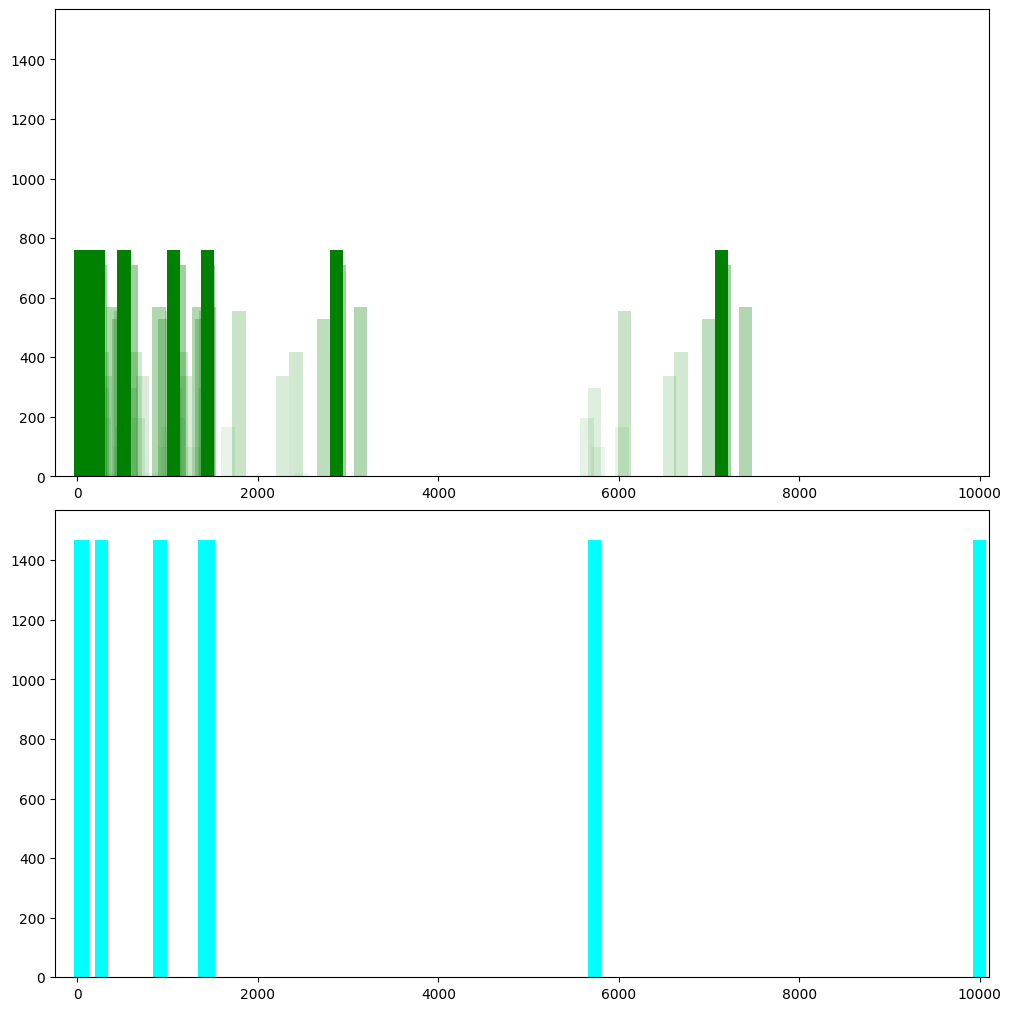

In [24]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 10))

alpha_value = 0.05
for i in range(0, len(boundaries_list)-1, int(len(boundaries_list)/10)):
# for i in range(0, len(boundaries_list)-1):
    temp_list = boundaries_list[i][0]
    temp_height = boundaries_list[i][1]
    alpha_value = alpha_value * 1.2
    for i in range(len(temp_list)-1):
        current_el = temp_list[i]
        next_el = temp_list[i+1]
        axs[0].bar((current_el + next_el)/2, temp_height, color='green', width = 150, alpha = alpha_value)
    

last_list = boundaries_list[-1][0]
last_height = boundaries_list[-1][1]
for i in range(len(last_list)-1):
    current_el = last_list[i]
    next_el = last_list[i+1]
    axs[0].bar((current_el + next_el)/2, last_height, color='green', width = 150, alpha = 1)


for i in range(len(temp_cp_dataset)-1):
    current_el = temp_cp_dataset[i]
    next_el = temp_cp_dataset[i+1]
    axs[1].bar((current_el + next_el)/2, step, color='cyan', width = 150, alpha = 1)

axs[0].set_ylim(0, step + 100)
axs[1].set_ylim(0, step + 100)
axs[0].set_xlim(-250, max(temp_cp_dataset) + 100)
axs[1].set_xlim(-250, max(temp_cp_dataset) + 100)
    
plt.show()